In [6]:
using Distributions
using LaTeXStrings
using Roots
using StatsPlots
default(fmt=:png, legendfontsize=12, guidefontsize=12)
using SymPy

cubic equation for x = z²: 

                                                      2    
    /    x\ /         x\           /                x\     
- x*|k + -|*|-k + n + -| + (n + x)*|k - p*(n + x) + -|  = 0
    \    2/ \         2/           \                2/     


(k, n, p) = (3, 10, 0.6) = (3, 10, 0.6)
pvalue_score(k, n, p) = 0.05280751141611362
pvalue_agresti_coull(k, n, p) = 0.056688740940858365
pvalue_wald(k, n, p) = 0.03843393023678172



11×4 Matrix{Float64}:
 0.0  0.0          0.0          0.0384339
 0.1  0.035015     0.043593     0.167546
 0.2  0.429195     0.432326     0.490153
 0.3  1.0          1.0          1.0
 0.4  0.518605     0.51993      0.490153
 0.5  0.205903     0.210131     0.167546
 0.6  0.0528075    0.0566887    0.0384339
 0.7  0.0057755    0.00696908   0.0057755
 0.8  7.72268e-5   0.000123552  0.000559906
 0.9  2.53963e-10  1.04551e-9   3.46711e-5
 1.0  0.0          0.0          1.36219e-6

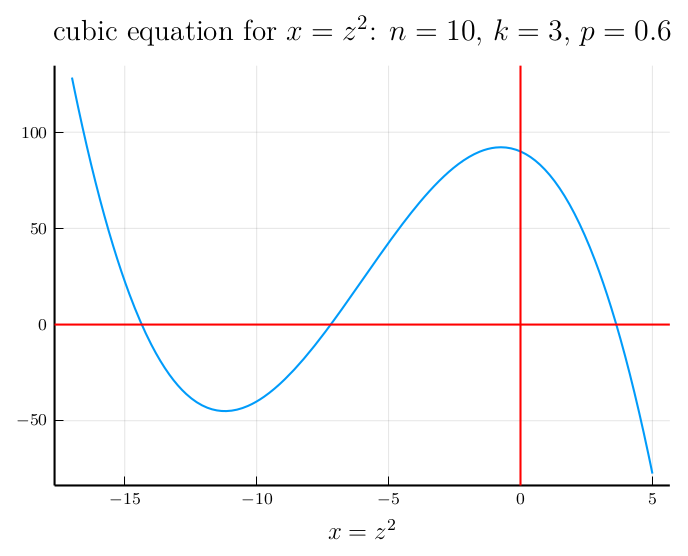

In [20]:
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_score(k, n, p)
    bin = Binomial(n, p)
    z = safediv(k - mean(bin), std(bin))
    2ccdf(Normal(), abs(z))
end

function pvalue_wald(k, n, p)
    bin = Binomial(n, p)
    p̂ = k/n
    z = safediv(k - mean(bin), √(n*p̂*(1-p̂)))
    2ccdf(Normal(), abs(z))
end

# z²に関する3次方程式
function _eq_agresti_coull(z², k, n, p)
    k̃, ñ = k + z²/2, n + z²
    ñ * (k̃ - ñ*p)^2 - z² * k̃ * (ñ - k̃)
end

# z²に関する3次方程式を解く
function z²_agresti_coull(k, n, p)
    f(t) = _eq_agresti_coull(exp(t), k, n, p)
    (1 - p ≈ 1 || p ≈ 1) && return oftype(p, Inf)
    k ≈ n*p && return zero(p)
    z² = exp(find_zero(f, (-1e2, 1e2)))
end

pvalue_agresti_coull(k, n, p) = 2ccdf(Normal(), √z²_agresti_coull(k, n, p))

@syms x, k, n, p
print("cubic equation for x = z²: ")
Eq(_eq_agresti_coull(x, k, n, p), 0) |> display
println()

@show k, n, p = 3, 10, 0.6
@show pvalue_score(k, n, p) pvalue_agresti_coull(k, n, p) pvalue_wald(k, n, p)
println()
stack(([p, pvalue_score(k, n, p), pvalue_agresti_coull(k, n, p), pvalue_wald(k, n, p)] for p in 0:0.1:1); dims=1) |> display
println()

pgfplotsx()
#gr()
plot(z² -> _eq_agresti_coull(z², k, n, p), -17, 5; label="")
hline!([0]; label="", c=:red)
vline!([0]; label="", c=:red)
plot!(xguide=L"x = z^2")
title!(L"cubic equation for $x = z^2$: $n=%$n$, $k=%$k$, $p=%$p$")
plot!(size=(500, 350)) |> display

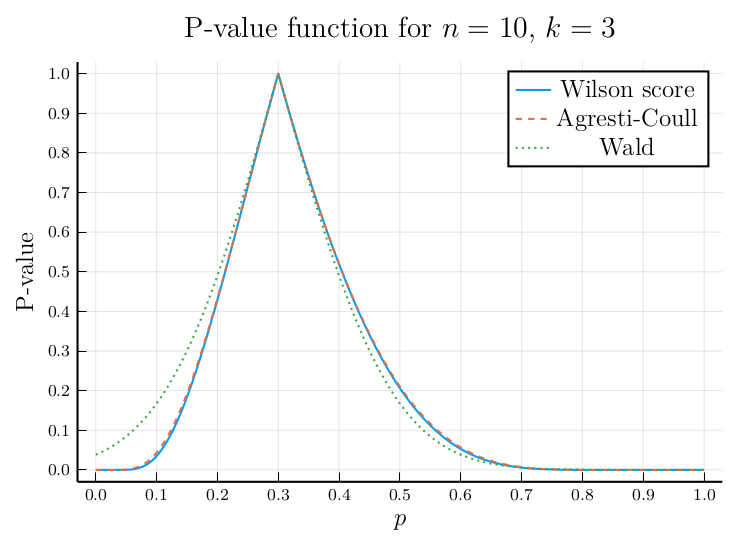

In [21]:
pgfplotsx()
#gr()
k, n = 3, 10
plot()
plot!(p -> pvalue_score(k, n, p), 0, 1; label="Wilson score")
plot!(p -> pvalue_agresti_coull(k, n, p), 0, 1; label="Agresti-Coull", ls=:dash)
plot!(p -> pvalue_wald(k, n, p), 0, 1; label="Wald", ls=:dot)
plot!(legend=:topright)
title!(L"P-value function for $n=%$n$, $k=%$k$")
plot!(xtick=-0.2:0.1:1, ytick=0:0.1:1)
plot!(xguide=L"p", yguide="P-value")
plot!(size=(500, 350))

In [4]:
function confint_score(k, n, α = 0.05)
    z = cquantile(Normal(), α/2)
    p̂ = k/n
    sehat² = p̂ * (1 - p̂) / n
    a, b = 1 + z^2/n, p̂ + z^2/(2n)
    sqrtD = z * √(sehat² + z^2/(4n^2))
    p_L = (b - sqrtD) / a
    p_U = (b + sqrtD) / a
    [p_L, p_U]
end

function confint_wald(k, n, α = 0.05)
    z = cquantile(Normal(), α/2)
    p̂ = k/n
    sehat = √(p̂ * (1 - p̂) / n)
    p_L = p̂ - z*sehat
    p_U = p̂ + z*sehat
    [p_L, p_U]
end

function confint_agresti_coull(k, n, α = 0.05)
    z = cquantile(Normal(), α/2)
    k̃, ñ = k + z^2/2, n + z^2
    confint_wald(k̃, ñ, α)
end

confint_agresti_coull (generic function with 2 methods)

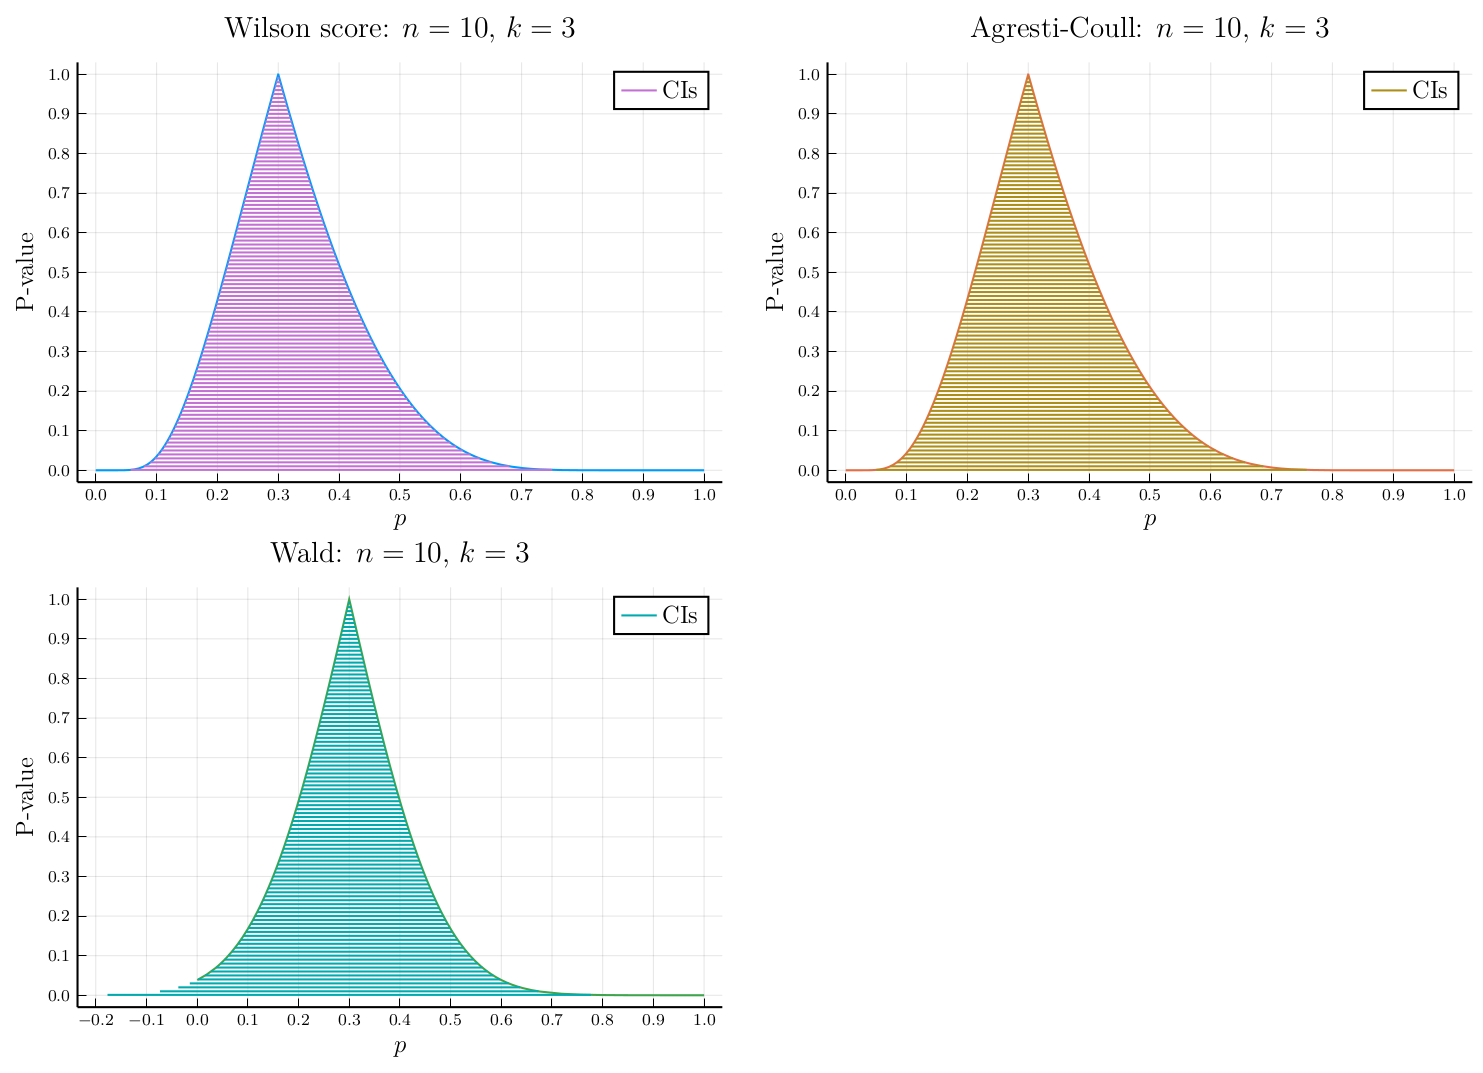

In [5]:
pgfplotsx()
#gr()

P = plot()
plot!(p -> pvalue_score(k, n, p), 0, 1; label="", c=1)
for α in [0.001; 0.01:0.01:1]
    ci = confint_score(k, n, α)
    plot!(ci, fill(α, 2); label=(α==1 ? "CIs" : ""), c=4)
end
title!(L"Wilson score: $n=%$n$, $k=%$k$")

Q = plot()
plot!(p -> pvalue_agresti_coull(k, n, p), 0, 1; label="", c=2)
for α in [0.001; 0.01:0.01:1]
    ci = confint_agresti_coull(k, n, α)
    plot!(ci, fill(α, 2); label=(α==1 ? "CIs" : ""), c=5)
end
title!(L"Agresti-Coull: $n=%$n$, $k=%$k$")

R = plot()
plot!(p -> pvalue_wald(k, n, p), -0.2, 1; label="", c=3)
for α in [0.001; 0.01:0.01:1]
    ci = confint_wald(k, n, α)
    plot!(ci, fill(α, 2);  label=(α==1 ? "CIs" : ""), c=6)
end
title!(L"Wald: $n=%$n$, $k=%$k$")

plot(P, Q, R; size=(1000, 700), layout=(2, 2))
plot!(xtick=-0.2:0.1:1, ytick=0:0.1:1)
plot!(xguide=L"p", yguide="P-value")
plot!(legend=:topright)
#plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)